<a href="https://colab.research.google.com/github/ViswanadhaReddy08/RIDE-SHARE-APPLICATION-/blob/main/ipl_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


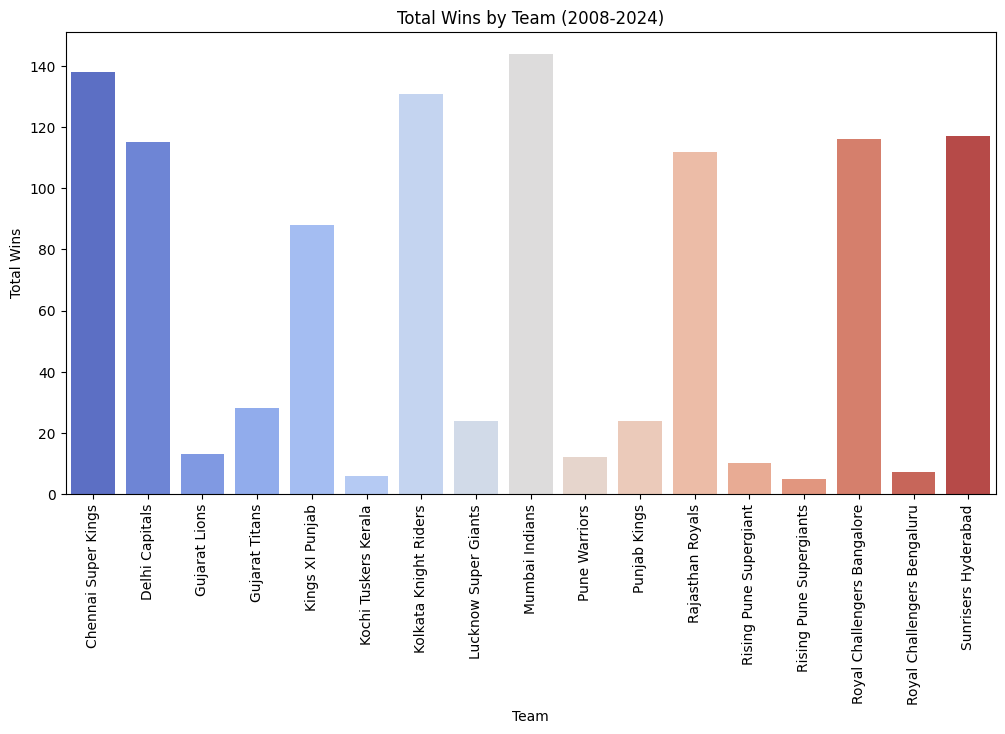

<ipython-input-4-89f66ab05cba>:55: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features = features.replace(team_encoding)
<ipython-input-4-89f66ab05cba>:56: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target = target.replace(team_encoding)


Random Forest Accuracy: 0.4725
XGBoost Accuracy: 0.5459
Gradient Boosting Accuracy: 0.5550
Logistic Regression Accuracy: 0.2385
SVM Accuracy: 0.2569
KNN Accuracy: 0.4725
ANN Accuracy: 0.3853
LSTM Accuracy: 0.4817
Best Model: Gradient Boosting with Accuracy: 0.5550
Predicted Winner for IPL 2025 Match (CSK vs MI, CSK wins toss & fields): Chennai Super Kings


In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Load Data
matches = pd.read_csv('/content/mydrive/MyDrive/brain dead/matches.csv')
deliveries = pd.read_csv('/content/mydrive/MyDrive/brain dead/deliveries.csv')

# Data Cleaning
matches.drop(columns=['umpire1', 'umpire2', 'method'], inplace=True)
matches['date'] = pd.to_datetime(matches['date'])
matches.replace({'Delhi Daredevils': 'Delhi Capitals', 'Deccan Chargers': 'Sunrisers Hyderabad'}, inplace=True)
matches.dropna(subset=['winner'], inplace=True)

# Feature Engineering
matches['win_by'] = np.where(matches['result'] == 'runs', matches['result_margin'], -matches['result_margin'])
matches['toss_win_bat'] = (matches['toss_decision'] == 'bat').astype(int)

# Aggregated Team Performance Metrics
def get_team_stats():
    team_stats = matches.groupby('winner').agg({'id': 'count', 'win_by': 'mean'}).reset_index()
    team_stats.columns = ['Team', 'Total Wins', 'Avg Win Margin']
    return team_stats

team_stats = get_team_stats()

# EDA - Team Performance
plt.figure(figsize=(12,6))
sns.barplot(x='Team', y='Total Wins', hue='Team', data=team_stats, palette='coolwarm', legend=False)
plt.xticks(rotation=90)
plt.title("Total Wins by Team (2008-2024)")
plt.show()

# Winner Prediction Model
features = matches[['team1', 'team2', 'toss_winner', 'toss_win_bat']]
target = matches['winner']

# Encoding categorical teams
teams = list(set(matches['team1'].unique()).union(set(matches['team2'].unique())))
team_encoding = {team: idx for idx, team in enumerate(teams)}
features = features.replace(team_encoding)
target = target.replace(team_encoding)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Train Multiple Models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "SVM": SVC(kernel='linear', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

best_model = None
best_accuracy = 0
accuracy_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model

# Deep Learning Model
num_classes = len(team_encoding)
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

ann_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_ann = ann_model.fit(X_train, y_train_categorical, epochs=50, batch_size=32, validation_data=(X_test, y_test_categorical), verbose=0)
ann_accuracy = max(history_ann.history['val_accuracy'])
accuracy_scores["Artificial Neural Network"] = ann_accuracy
print(f"ANN Accuracy: {ann_accuracy:.4f}")

# LSTM Model
X_train_lstm = X_train.values.reshape(-1, 4, 1)
X_test_lstm = X_test.values.reshape(-1, 4, 1)

y_train_lstm = to_categorical(y_train, num_classes=num_classes)
y_test_lstm = to_categorical(y_test, num_classes=num_classes)

lstm_model = Sequential([
    Input(shape=(4, 1)),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(num_classes, activation='softmax')
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history_lstm = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm), verbose=0)
lstm_accuracy = max(history_lstm.history['val_accuracy'])
accuracy_scores["LSTM"] = lstm_accuracy
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")

# Identify the Best Model
best_model_name = max(accuracy_scores, key=accuracy_scores.get)
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_name]:.4f}")

# Prediction for IPL 2025
def predict_winner(team1, team2, toss_winner, toss_decision):
    input_data = pd.DataFrame([[team_encoding[team1], team_encoding[team2], team_encoding[toss_winner], int(toss_decision == 'bat')]],
                              columns=['team1', 'team2', 'toss_winner', 'toss_win_bat'])
    winner_encoded = best_model.predict_proba(input_data).argmax()
    return list(team_encoding.keys())[list(team_encoding.values()).index(winner_encoded)]

# Example Prediction
print("Predicted Winner for IPL 2025 Match (CSK vs MI, CSK wins toss & fields):", predict_winner('Chennai Super Kings', 'Mumbai Indians', 'Chennai Super Kings', 'field'))



In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load Data
matches = pd.read_csv('/content/mydrive/MyDrive/brain dead/matches.csv')
deliveries = pd.read_csv('/content/mydrive/MyDrive/brain dead/deliveries.csv')


# Data Cleaning
matches.drop(columns=['umpire1', 'umpire2', 'method'], inplace=True)
matches['date'] = pd.to_datetime(matches['date'])
matches.replace({'Delhi Daredevils': 'Delhi Capitals', 'Deccan Chargers': 'Sunrisers Hyderabad'}, inplace=True)
matches.dropna(subset=['winner'], inplace=True)

# Feature Engineering
matches['win_by'] = np.where(matches['result'] == 'runs', matches['result_margin'], -matches['result_margin'])
matches['toss_win_bat'] = (matches['toss_decision'] == 'bat').astype(int)
matches['win_rate'] = matches.groupby('winner')['winner'].transform('count') / matches.shape[0]

# Encoding categorical teams
teams = list(set(matches['team1'].unique()).union(set(matches['team2'].unique())))
team_encoding = {team: idx for idx, team in enumerate(teams)}
matches.replace({'team1': team_encoding, 'team2': team_encoding, 'toss_winner': team_encoding, 'winner': team_encoding}, inplace=True)

features = matches[['team1', 'team2', 'toss_winner', 'toss_win_bat', 'win_rate']]
target = matches['winner']

# Normalize Data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42, stratify=target)

# Train Multiple Models with Hyperparameter Tuning
param_grid = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30]}
rf_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5).fit(X_train, y_train)
xgb_model = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=5).fit(X_train, y_train)
gb_model = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid, cv=5).fit(X_train, y_train)

models = {
    "Random Forest": rf_model.best_estimator_,
    "XGBoost": xgb_model.best_estimator_,
    "Gradient Boosting": gb_model.best_estimator_,
    "Logistic Regression": LogisticRegression(max_iter=3000),
    "SVM": SVC(kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=3)
}

best_model = None
best_accuracy = 0
accuracy_scores = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = model

# Stacking Classifier
stacking_model = StackingClassifier(estimators=[('rf', rf_model.best_estimator_), ('xgb', xgb_model.best_estimator_), ('gb', gb_model.best_estimator_)], final_estimator=LogisticRegression())
stacking_model.fit(X_train, y_train)
stacking_acc = accuracy_score(y_test, stacking_model.predict(X_test))
accuracy_scores["Stacking Model"] = stacking_acc
print(f"Stacking Model Accuracy: {stacking_acc:.4f}")

# Deep Learning Model
num_classes = len(team_encoding)
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

ann_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
history_ann = ann_model.fit(X_train, y_train_categorical, epochs=150, batch_size=32, validation_data=(X_test, y_test_categorical), verbose=0, callbacks=[early_stopping])
ann_accuracy = max(history_ann.history['val_accuracy'])
accuracy_scores["Artificial Neural Network"] = ann_accuracy
print(f"ANN Accuracy: {ann_accuracy:.4f}")

# LSTM Model
X_train_lstm = X_train.reshape(-1, 5, 1)
X_test_lstm = X_test.reshape(-1, 5, 1)

lstm_model = Sequential([
    Input(shape=(5, 1)),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
history_lstm = lstm_model.fit(X_train_lstm, y_train_categorical, epochs=150, batch_size=32, validation_data=(X_test_lstm, y_test_categorical), verbose=0, callbacks=[early_stopping])
lstm_accuracy = max(history_lstm.history['val_accuracy'])
accuracy_scores["LSTM"] = lstm_accuracy
print(f"LSTM Accuracy: {lstm_accuracy:.4f}")

# Identify the Best Model
best_model_name = max(accuracy_scores, key=accuracy_scores.get)
print(f"Best Model: {best_model_name} with Accuracy: {accuracy_scores[best_model_name]:.4f}")


<ipython-input-8-ac36dc735c08>:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matches.replace({'team1': team_encoding, 'team2': team_encoding, 'toss_winner': team_encoding, 'winner': team_encoding}, inplace=True)
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits

Random Forest Accuracy: 0.9725
XGBoost Accuracy: 0.9954
Gradient Boosting Accuracy: 0.9862
Logistic Regression Accuracy: 0.3532
SVM Accuracy: 0.6009
KNN Accuracy: 0.7569


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Stacking Model Accuracy: 0.9908
ANN Accuracy: 0.8670
LSTM Accuracy: 0.2706
Best Model: XGBoost with Accuracy: 0.9954
